Tutorial 7: Adaptive Pixelization
=================================

In this tutorial we'll use a new _Pixelization_, called the VoronoiMagnification _Pixelization_. This pixelization
doesn't use a uniform _Grid_ of rectangular pixels, but instead uses an irregular 'Voronoi' pixels. So, why do we
want to do that? Lets take another quick look at the rectangular grid..

In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


We'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's _MassProfile_ is an _EllipticalIsothermal_.
 - The source galaxy's _LightProfile_ is an _EllipticalSersic_.

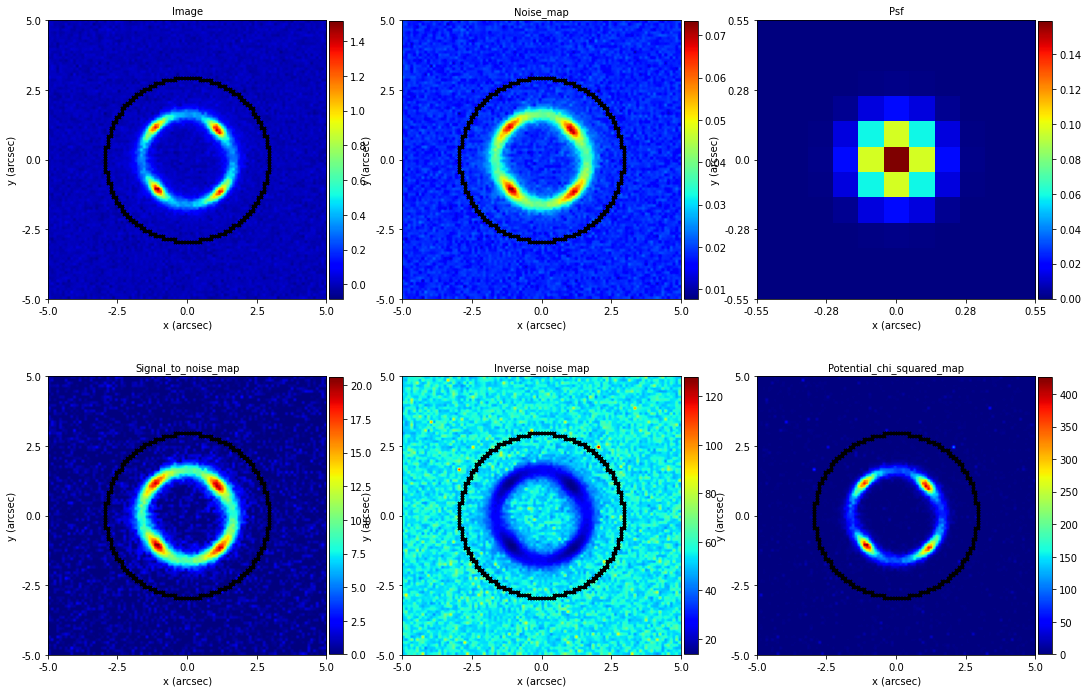

In [2]:
from howtolens.simulators.chapter_4 import lens_sie__source_sersic

dataset_type = "chapter_4"
dataset_name = "lens_sie__source_sersic"
dataset_path = f"{workspace_path}/howtolens/dataset/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)

mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=2, radius=3.0
)

aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

The lines of code below do everything we're used to, that is, setup an image, mask it, trace it via a tracer, 
setup the rectangular mapper, etc.

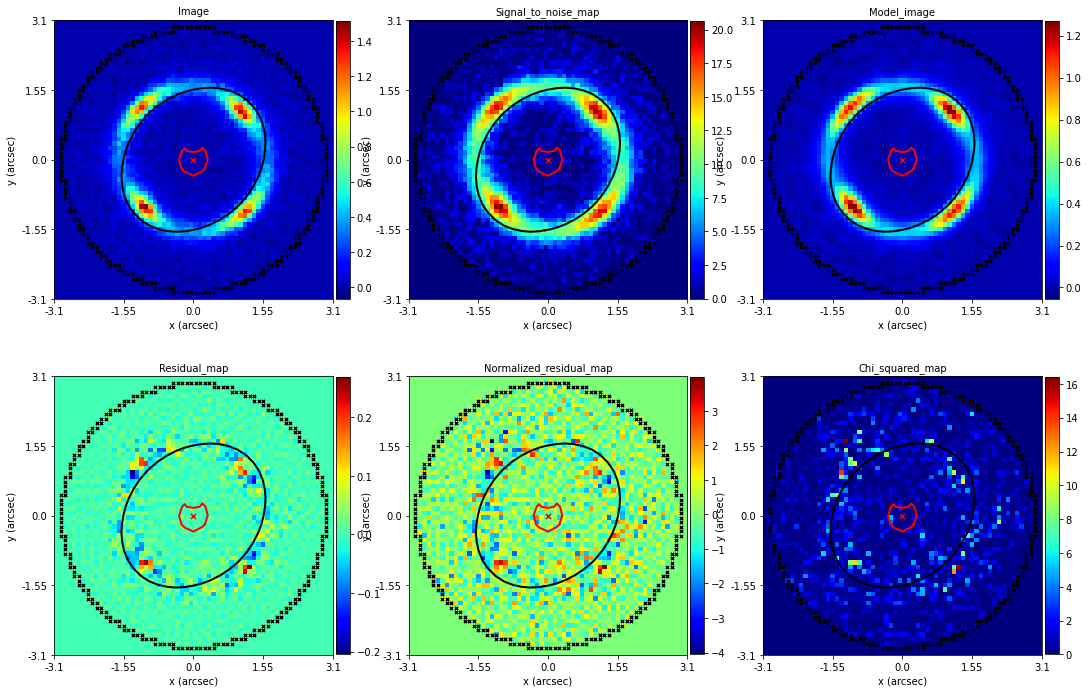

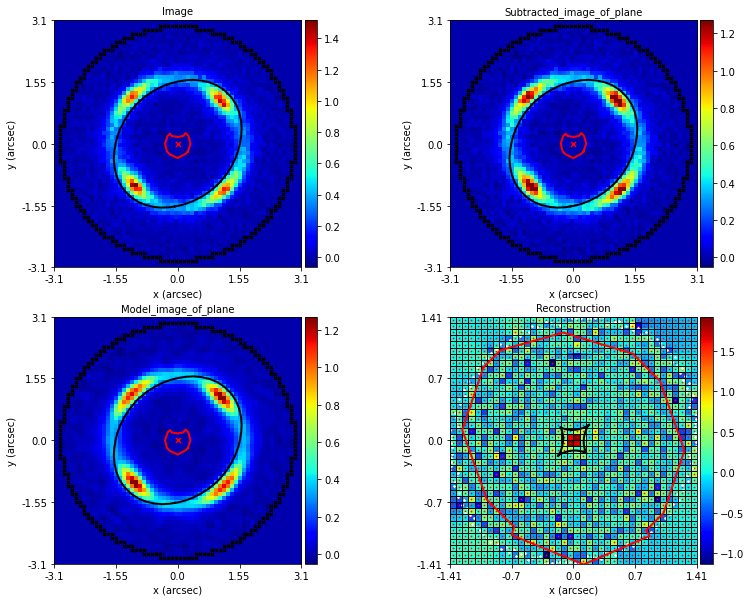

In [3]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.111111, 0.0), einstein_radius=1.6
    ),
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=0.5),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))
aplt.FitImaging.subplot_of_plane(
    fit=fit, plane_index=1, include=aplt.Include(mask=True)
)

Okay, so lets think about the _Rectangular_ _Pixelization_. Is this the optimal way to reconstruct our source? Are 
there features in the source-plane that arn't ideal? How do you think we could do a better job?

Well, given we're doing a whole tutorial on using a different _Pixelization_to this grid, you've probably guessed that
it isn't optimal. Infact, its pretty rubbish, and not a _Pixelization_we should actually want to model any lenses with!

So what is wrong with the grid? Well, lets think about the source reconstruction.

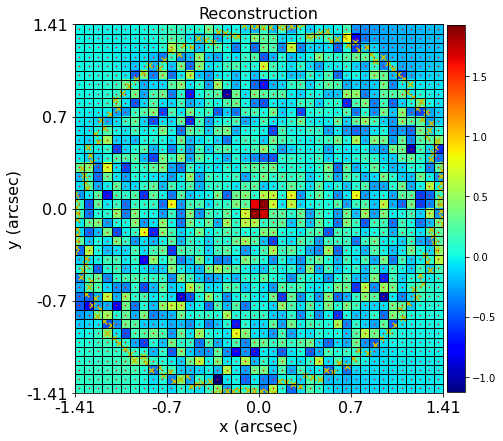

In [4]:
aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

There is one clear problem, we are using a small number of the total source pixels to reconstruct the source. The 
majority of source pixels are located away from the source. By my estimate, we're using just 16 pixels (the central 
4x4 grid) out of the 1600 pixels to actually fit the data! The remaining ~1500 pixels are doing *nothing* but fit noise.

This is a waste and our analysis will take longer to run because of it. However, more importantly, it means that our 
Bayesian regularization scheme is sub-optimal. In tutorial 4, we discussed how the Bayesian log evidence of the 
regularization wants to obtain the *simplest* source solution possible. That is the solution which fits the data 
well using the fewest source pixels. Clearly, if we dedicating a huge number of source pixels to doing *nothing*, our 
source reconstruction will be unecessarily complex (and therefore lower log_evidence).

If our _Pixelization_ could 'focus' its pixels where we actually have more data, e.g. the highly magnified regions of 
the source-plane, we could reconstruct the source using far fewer pixels. That'd be great both for computational 
efficiency and increasing the Bayesian log evidence. This is what the Voronoi _Pixelization_ does.

To achieve this, we first compute an 'image-plane sparse grid', which is a set of sparse coordinates in the image-plane 
that will be ray-traced to the source-plane and define the centres of our source-pixel grid. We compute this _Grid_ 
directly from a _Pixelization_, by passing it a grid.

In [5]:
adaptive = al.pix.VoronoiMagnification(shape=(20, 20))

image_plane_sparse_grid = adaptive.sparse_grid_from_grid(grid=masked_imaging.grid)

We can plot this _Grid_ over the image, to see that it is a coarse _Grid_ over-laying the image itself.

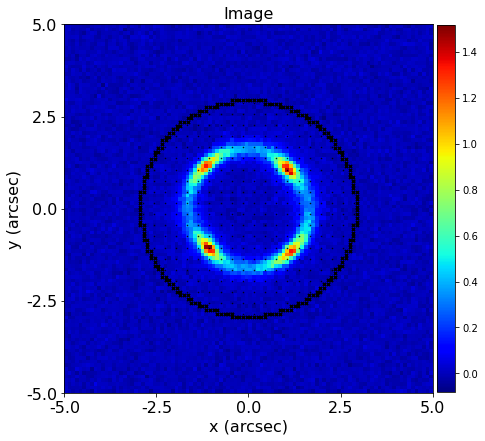

In [6]:
aplt.Imaging.image(imaging=imaging, grid=image_plane_sparse_grid, mask=mask)

When we pass a _Tracer_ a source galaxy with this _Pixelization_ it automatically computes the ray-traced source-plane 
Voronoi _Pixelization_ using the _Grid_ above. Thus, our Voronoi _Pixelization_is used by the tracer's fit.

In [7]:
source_galaxy = al.Galaxy(
    redshift=1.0, pixelization=adaptive, regularization=al.reg.Constant(coefficient=1.0)
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

If we look at the lens fit, we'll see that our source-plane no longer uses rectangular pixels, but Voronoi pixels!

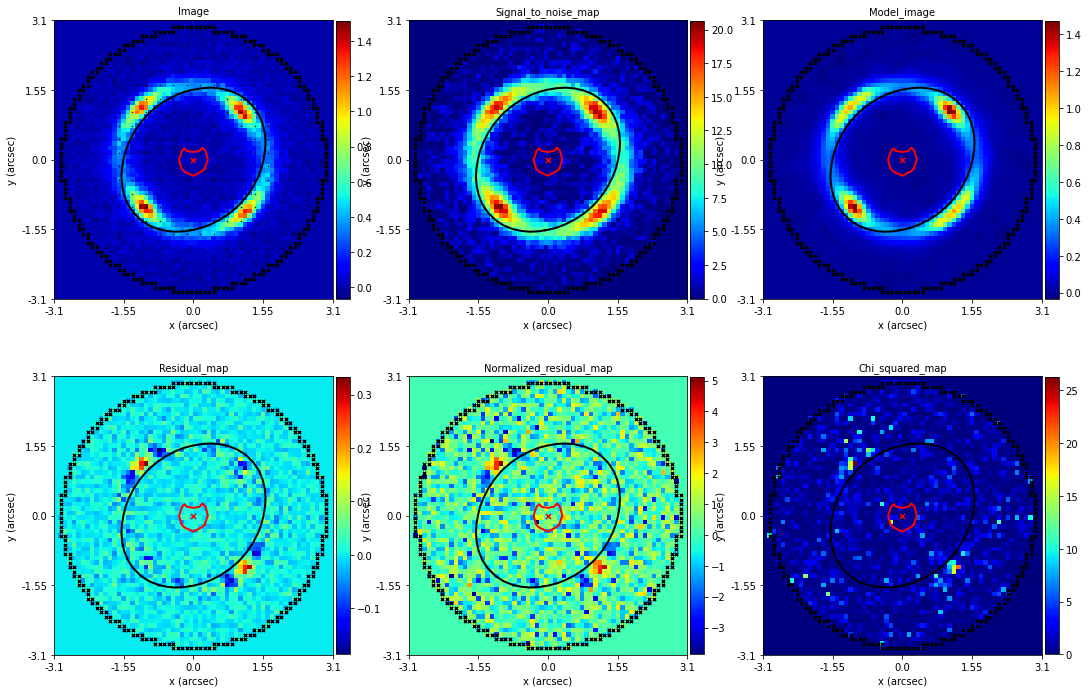

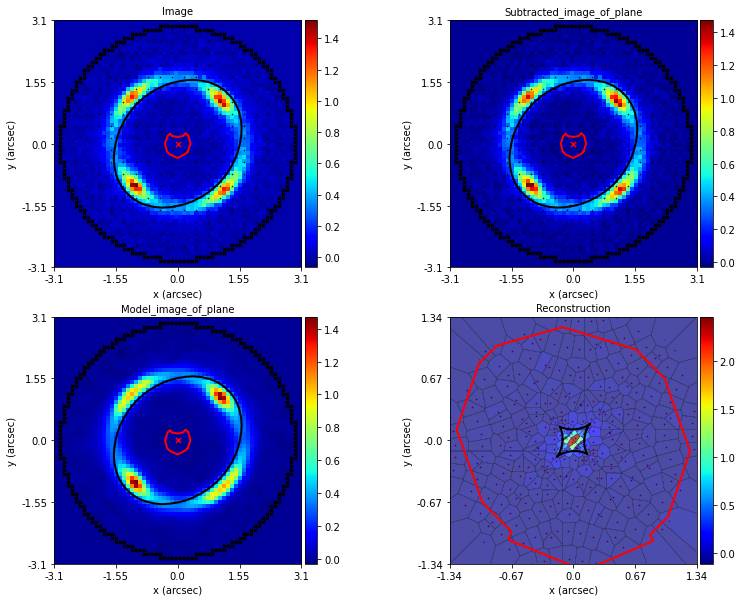

In [11]:
fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit,
    include=aplt.Include(
        mask=True,
        inversion_image_pixelization_grid=True,
        inversion_pixelization_grid=True,
    ),
)
aplt.FitImaging.subplot_of_plane(
    fit=fit, plane_index=1, include=aplt.Include(mask=True)
)

And we can take a closer inspection of the _Inversion_ itself.

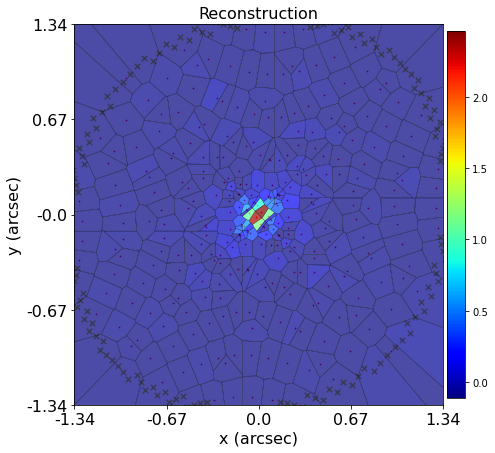

In [14]:
aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

Clearly, this is an improvement. We're using fewer pixels than the rectangular _Grid_ (400, instead of 1600), but 
reconstructing our source is far greater detail. A win all around? It sure is.

On our rectangular grid, we regularized each source pixel with its 4 neighbors. We compared their fluxes, summed 
the differences, and penalized solutions where the differences were large. For a Voronoi _Pixelization_, we do the same 
thing, now comparing each source-pixel with all other source-pixels with which it shares a direct vertex. This means that 
different source-pixels may be regularized with different numbers of source-pixels, depending on how many neighbors 
are formed.

However, this _VoronoiMagnification_ _Pixelization_ is still far from optimal. There are lots of source-pixels 
effectively fitting just noise. We may achieve even better solutions if the central regions of the source were 
reconstructed using even more pixels. So, how do we improve on this? Well, you'll have to wait until chapter 5, 
when we introduce PyAutoLens's adaptive functionality, or 'hyper-mode'.

In the mean time, you may wish to experiment with using both Rectangular and VoronoiMagnification _Grid_'s to fit 
lenses which can be easily achieve by changing the input pixeliation given to a pipeline.